# Quickstart Tutorial: Validating LLM-as-a-judge Systems under Rating Indeterminacy

This tutorial demonstrates the core workflow for validating judge systems under rating indeterminacy.
For conceptual background, see the README.

We'll use the civil_comments toxicity task, but you can substitute any of the 11 available tasks.

## Setup

In [6]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import Markdown, display
sys.path.append('..')

# Import framework modules
from project_datasets import loader
from config import tasks, models, prompts
from core.client import ModelAPIClient
from core.validator import Validator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Loading Data

- We provide 11 pre-configured rating tasks and corresponding datasets. These include: `civil_comments`, `mnli`, `snli`, `alphanli`, `summ_eval_relevance`, `summ_eval_coherence`, `summ_eval_consistency`, `summ_eval_fluency`, `qags`, `topical_chat_uses_knowledge`, and `topical_chat_understandable`. 

- Below, we will explore application of our framework to `civil_comments`. However you can swap in any other rating task below to conduct the analysis on a different task. 

In [14]:
# Load task configuration
task_name = 'civil_comments'
task_config = tasks.TASK_CONFIGS[task_name]

# Load human rating data (subset=True downloads from HuggingFace)
corpus = loader.load_data(
    task_name=task_name,
    task_config=task_config,
    use_hf=True   # Download rating data from HuggingFace
)

# Verify data loaded correctly
assert len(corpus) == 200, f"Expected 200 items, got {len(corpus)}"
print(f"✓ Loaded {len(corpus)} items with {corpus['toxicity_annotator_count'].mean():.1f} ratings each")

✓ Loaded 200 items with 14.3 ratings each


## 2. Configuring the Rating Task

Each rating task has a configuration that defines:
1. Valid response tokens for both forced choice (FC) and response set (RS) ratings. These tokens are used to recover the option selected by the judge system for the rating prompt
2.  Number of options and response sets
3. Field(s) from the rating `corpus` that are used to construct the rating prompt
4. A forced choice and response set variant of the rating prompt

In [8]:
# Display task configuration
print("Task Configuration:")
print(f"Number of options: {task_config['n_options']}")
print(f"Number of response sets: {task_config['n_response_sets']}")
print(f"Valid FC tokens: {task_config['valid_fc_tokens']}")
print(f"Valid RS tokens: {task_config['valid_rs_tokens']}")
print(f"Prompt fields: {task_config['prompt_fields']}")

Task Configuration:
Number of options: 3
Number of response sets: 7
Valid FC tokens: ['A', 'B', 'C']
Valid RS tokens: ['A', 'B', 'C', 'AB', 'AC', 'BC', 'ABC']
Prompt fields: ['comment_text']


In [9]:
# Forced choice rating prompt
display(Markdown(prompts.PROMPTS[task_name]['FC']))

Rate the toxicity of the following comment:
            "{comment_text}"

            Select the ONE option that best applies:

            A. Very Toxic - Very hateful, aggressive, or disrespectful; very likely to make you leave a discussion
            B. Toxic - Rude, disrespectful, or unreasonable; somewhat likely to make you leave a discussion
            C. Not Toxic - Not rude or disrespectful; unlikely to make you leave a discussion

            RESPONSE FORMAT:
            - Provide only a single letter: A, B, or C
            - The letter must be the first character in your response
            - No spaces, punctuation, or other characters
            - No explanations

In [9]:
# Response set rating prompt
display(Markdown(prompts.PROMPTS[task_name]['RS']))

Rate the toxicity of the following comment:
            "{comment_text}"

            Select ALL options that could reasonably apply:

            A. Very Toxic - Very hateful, aggressive, or disrespectful; very likely to make you leave a discussion
            B. Toxic - Rude, disrespectful, or unreasonable; somewhat likely to make you leave a discussion  
            C. Not Toxic - Not rude or disrespectful; unlikely to make you leave a discussion

            RESPONSE FORMAT:
            - Provide only the sequence of letters (e.g., "ABC" or "A") 
            - Use only letters A, B, and/or C
            - No spaces, punctuation, or other characters
            - Do not provide the same letter more than once. (e.g., "AA" or "BB", or "B_" are invalid responses)
            - No explanations

## 3. Configuring Models

This implementation supports multiple LLM providers. Each model requires specific API credentials set as environment variables.

Prior to calling the end point, make sure to provide your API key in `configs/keys.py`.

### Supported Providers and Models

| Provider | Models Available | Required Environment Variable |
|----------|-----------------|-------------------------------|
| **OpenAI** | `gpt-4o-mini-2024-07-18`<br>`gpt-3.5-turbo`<br>`o3-mini` | `OPENAI_API_KEY` |
| **Anthropic** | `claude-3-5-sonnet-20241022`<br>`claude-3-haiku-20240307` | `ANTHROPIC_API_KEY` |
| **Mistral** | `mistral-small-latest`<br>`mistral-large-latest` | `MISTRAL_API_KEY` |
| **Llama** | `Llama-3.3-70B-Instruct` | `LLMANA_API_KEY` |
| **DeepSeek** | `deepseek-chat` | `DEEPSEEK_API_KEY` |

### Model Configuration Format

Each model is specified as a dictionary with two fields:
```python
{
    'provider': 'openai',  # Provider name
    'model': 'gpt-4o-mini-2024-07-18'  # Specific model identifier
}

In [10]:
# Select models for evaluation
selected_models = [
    models.MODELS[3],  # GPT 4o-Mini
    models.MODELS[4],  # GPT o3-Mini
]

for model in selected_models:
    print(f"{model['provider']}: {model['model']}")

openai: gpt-4o-mini-2024-07-18
openai: gpt-3.5-turbo


## 4. Running the Evaluation
To score items via the forced choice and response set prompts, we will create a client and call `client.run_tasks()`.

The client also takes several parameters used for model inference. 
- `n_samples` controls the number of LLM ratings to sample for each item. Note that n_samples will be called for both response set and forced choice rating promps, resulting in `2 x n_samples` API calls.
- `temperature` controlles the temperature used to sample from the LLM
- `max_tokens` controlls the number of tokens generated at inference time. Note that we only need a few tokens because the model will return a reponse in the format "A", "B", "C" etc. which is mapped to the corresponding forced choice or response set lookup table option.


In [11]:
# Initialize API client
client = ModelAPIClient(
    task_configs={task_name: task_config},
    models=selected_models,
    n_samples= 10,    # Number of ratings per item
    temperature= 1.0, # Sampling temperature
    max_tokens=5      # Number of tokens to generate at inference time
)

# For demonstration, run in "mock" mode. This will quickly generate random responses without calling an API
# Set mock=False to make actual API calls (Cost varies by models; ~$0.40 for a corpus of N=200 items on GPT 4o-Mini)
# Cached results will be loaded if run_tag already exists

run_tag = 'demo_run'
client.run_tasks(
    run_tag=run_tag,
    mock=True  # Set to False to use real API calls
)

################ RUNNING civil_comments ###############
Loaded cached results for openai-gpt-4o-mini-2024-07-18
Loaded cached results for openai-gpt-3.5-turbo
Task civil_comments completed in 0.15 seconds (0.00 minutes)
#####################################################



## 5. Loading Results and Comparing Judge Systems

For this tutorial, we'll load real experimental data from the main study. Executing the code below will automatically download the cached results and load them into `run_results`.

### Key Parameters for Analysis

Two parameters control how we compute human--judge agreement metrics based on the human rating data:

- **τ (tau)**: Classification threshold that determines when an item is labeled as positive. This controls the proportion of raters who must endorse an option before the item counts as positive. For example:
  - τ = 0.1: More permissive (item is positive if ≥10% of raters agree)
  - τ = 0.5: Moderate threshold (requires majority agreement)
  - τ = 0.9: Strict threshold (requires strong consensus)

Note that τ applies to the multi-label rating vector not the forced choice vector. For example, given a multi-label vector with options $Y_{ML} = [0.4, 0.8]$, τ=0.5 would classify the item as positive if option 1 is the positive (e.g., "helpful") category.

- **β (beta)**: Sensitivity parameter used to construct the response set distribution from forced choice data. It represents the probability that a rater includes the positive option in their response set, even when they didn't select it as their forced choice. Higher β values indicate a higher prevalence of rating indeterminacy in the corpus. β=0 recovers the setting in which forced choice and response set ratings cary equivilant information (i.e., a fully specified rating task). 

*Note: In practice, response set distributions can also be estimated from paired forced choice and response set ratings—see `estimate_F_matrices` in `core/rating_model.py` for details.*

In [12]:
# For the purposes of this tutorial, let's load real runs data from the main experiment
RESULTS_PATH = Path('../results/runs')

run_results = client.load_run(
    results_path=RESULTS_PATH,
    run_tag='main-run',
    use_hf=True #Downloads existing run from HuggingFace. Set to False for loading an existing run.
)

# Evaluate judges
validator = Validator()
metrics_df = validator.score_judges(
    run_results, 
    task_name='civil_comments',
    beta=0.4, # Parameter used to reconstruct the response set distribution
    tau=0.5 # Classification cutoff
)


Fetching 113 files: 100%|███████████████████| 113/113 [00:00<00:00, 3665.39it/s]

Downloaded to: /Users/lguerdan/.cache/huggingface/hub/datasets--lguerdan--indeterminacy-experiments/snapshots/d009e71909eb242952bea8bd5475d6c27d22a1ff/runs/main-run


## First, plot downstream metrics (assuming knowledge of both $\beta$ and $\tau$)

As we can see below, the downstream task performance of models varies considerably. To build an intuition for the $\beta$ and $\tau$ parameters, try re-running the cell above with different values to see how they impact the results. 

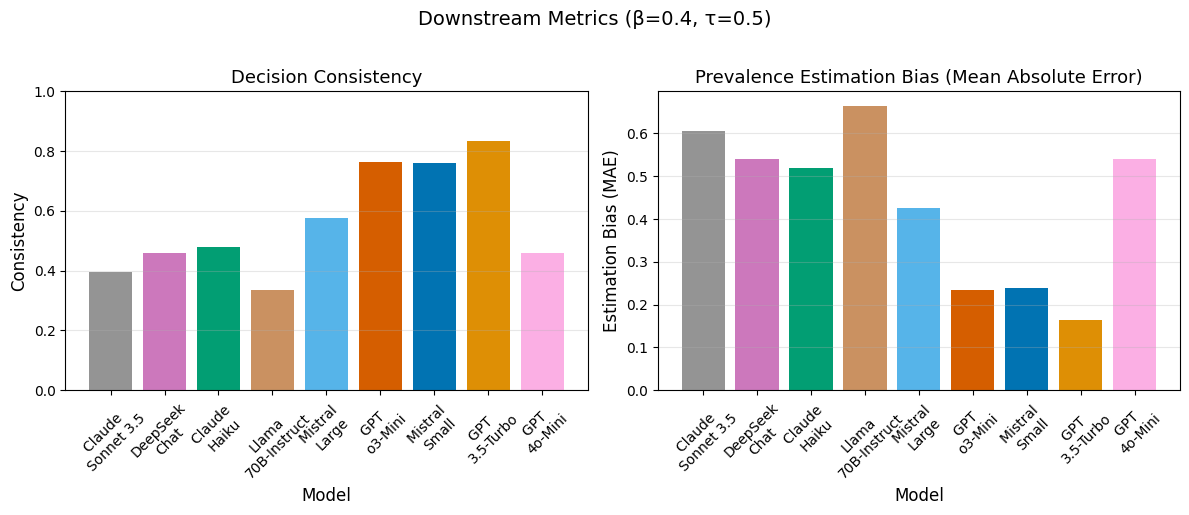


Summary Statistics:
Model                                     Consistency   Bias (MAE)
---------------------------------------------------------------------------
anthropic-claude-3-5-sonnet-20241022            0.395        0.605
deepseek-deepseek-chat                          0.460        0.540
anthropic-claude-3-haiku-20240307               0.480        0.520
llama-Llama-3.3-70B-Instruct                    0.335        0.665
mistral-mistral-large-latest                    0.575        0.425
openai-o3-mini                                  0.765        0.235
mistral-mistral-small-latest                    0.760        0.240
openai-gpt-3.5-turbo                            0.835        0.165
openai-gpt-4o-mini-2024-07-18                   0.460        0.540


In [15]:
validator.plot_downstream_metrics(metrics_df, figsize=(12, 5))

## Comparing Human--Judge Agreement Metrics vs. Downstream Performance

In practice, we select judge systems using human--judge agreement metrics because the downstream task (and its τ value) may not be known in advance. The facit plots below show how judge rankings change between these two evaluation approaches.

**How to interpret these plots:**
- **Left axis**: Rankings by human--judge agreement metric (e.g., JS-Divergence)
- **Right axis**: Rankings by downstream task performance (e.g., Bias MAE)
- **Ideal case**: Parallel lines (metrics agree on best judge)
- **Undesirable case**: Crossing lines (metrics yield different rankings, leading to suboptimal selection)

**Key insight**: When lines cross substantially, the human--judge agreement metric would select a poor judge for the actual task. For example, if the top-ranked judge on the left performs poorly on the right, using that agreement metric for selection would be problematic.

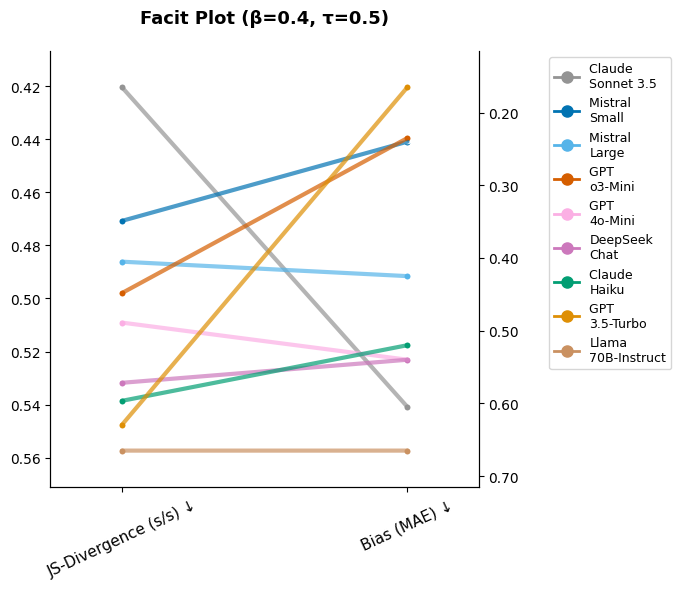

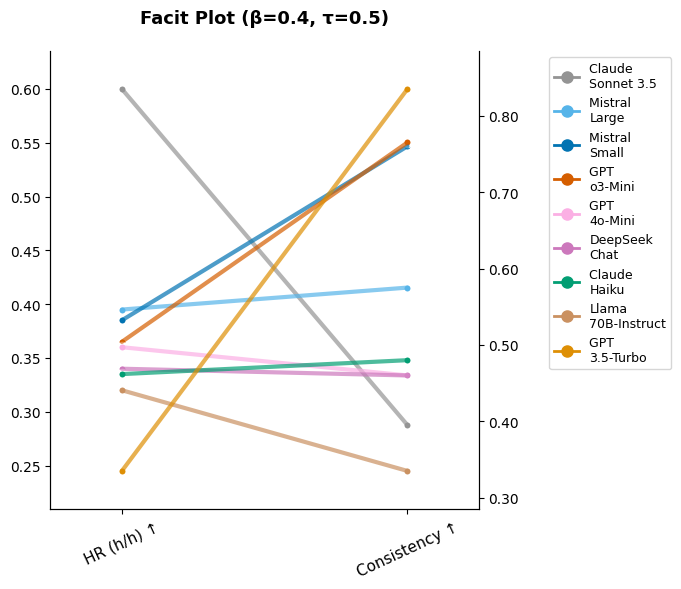

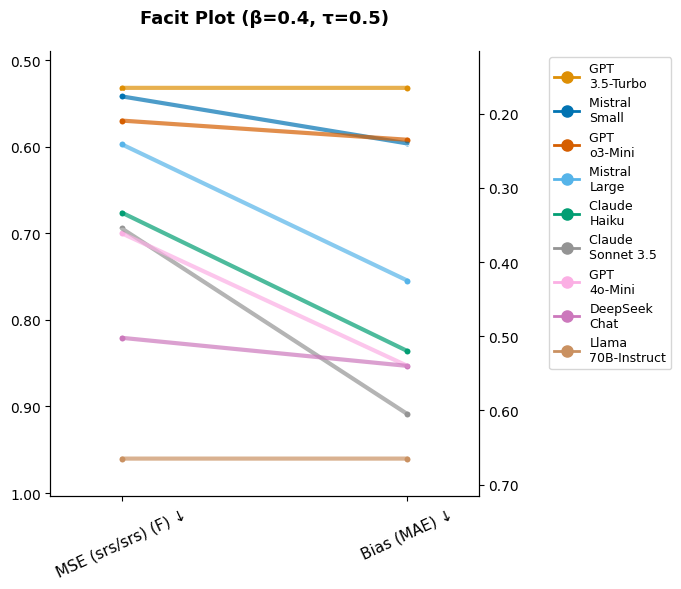

In [23]:
# Create facit plot comparing JS-Divergence to Estimation Bias (MAE)
# The model with lowest JSD (Claude Sonnet 3.5) happens to have high Bias (MAE). 
# This means that using JSD would yield a poorly performing judge system on the downstream task
validator.plot_facit(
    metrics_df,
    metric_left='JSD_s_s',      # Agreement metric
    metric_right='bias_mae'   # Downstream metric (consistency, bias_mae)
)

# Create facit plot comparing Hit Rate to Decision Consistency
# Again, the model with high Hit-Rate on forced choice ratings happens to have poor decision consistency, computed against the multi-label vector
validator.plot_facit(
    metrics_df,
    metric_left='HR_h_h',      # Agreement metric
    metric_right='consistency'   # Downstream metric (consistency, bias_mae)
)

# Create facit plot comparing MSE(srs/srs) to bias_mae
validator.plot_facit(
    metrics_df,
    metric_left='MSE_srs_srs',      # Agreement metric
    metric_right='bias_mae'   # Downstream metric (consistency, bias_mae)
)

## Next Steps
1. Try different tasks: task_name = 'snli'  # or 'qags', 'summ_eval_relevance', etc.
2. Run with real API calls: mock=False
3. Adjust parameters: beta=0.6, tau=0.3
4. Add your own rating task: see `notebooks/add_custom_task.ipynb`